In [12]:
import pandas as pd
import numpy as np
import math
import keras
from keras.layers import LSTM, Embedding
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,precision_score, precision_recall_fscore_support as score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import FeatureAgglomeration
from sklearn import cluster
import keras
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical  
import keras.backend as K
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,precision_score, precision_recall_fscore_support as score
from matplotlib import colors
import itertools
from wordcloud import WordCloud, STOPWORDS
import random

# Analysis of Amazon Reviews Using LSTM Neural Networks

Today we are going to be looking at a dataset of ~1 million amazon kindle book reviews. The dataset can be found [here](https://www.kaggle.com/bharadwaj6/kindle-reviews). Since we are focused on using LSTM neural networks we are only going to be looking at the `overall`, `reviewText` and `summary` columns, which are the score (out of 5) of the review, and the synopsis and body of each review.   

In [7]:
data = pd.read_json('kindle_reviews.json', lines = True)

In [3]:
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


### Visualization Functions

I define a couple of visualization functions to help us monitor how our networks are training over epochs, as well as to monitor the accuracy and model statistics of our models. I also include a function to plot a simple wordcloud.

In [4]:
def dnn_plots(history):
    '''
        inputs:
            history: a fitted neural network
    '''
    history_dict = history.history
    losses = history_dict['loss']
    val_losses = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    epochs = range(1,len(acc)+1)
    
    plt.plot(epochs, losses, label = 'Training Loss')
    plt.plot(epochs, val_losses, label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.plot(epochs, acc, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.clf()
    
    return

In [5]:
def plot_confusion_matrix(Y_test, predictions, classes):
    '''
        inputs:
            Y_test: test labels 
            predictions: predictions made by your model
            classes: [label of negative output, label of positive output]
    '''
    matrix = confusion_matrix(Y_test, predictions) 
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.OrRd)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = ",d"
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print('\nClasification report:\n', classification_report(Y_test, predictions))

    return plt

In [13]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def make_wordcloud(title,text):
    stopwords = set(STOPWORDS)
    # I add a few stopwords, this is because March, daily, and weekly are all associated with horoscope, so we dont
    # need to display all of them in our wordcloud
    stopwords.update(['Monthly','March','Daily','Weekly','VICE','Vice'])
    wc = WordCloud(max_words=1000,stopwords=stopwords, margin=10, random_state=1).generate(text)
    plt.imshow(wc.recolor(color_func=grey_color_func))
    plt.axis("off")
    plt.title(title)
    plt.show()
    plt.close()
    return 

## Data Visualization & Preprocessing

Instead of constructing a model which predicts the raw score of a given review, we instead classify each review as a 5-star review or a non 5-star review. I chose to do this because there are very uneven classes for reviews, and the task of classifying a 2-star vs. a 1-star review is nearly impossible - even for a human!

I chose to break the dataset up into 5-star and non 5-star because the distribution of classes was relatively even (more even than, say, a 4 or a bove vs 3 or below split), and I thought it would be interesting to be able to weed out the stellar reviews from the good to poor reviews.

I plot the distribution of the output as well as some wordclouds to help visualize the most common words in each output class.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


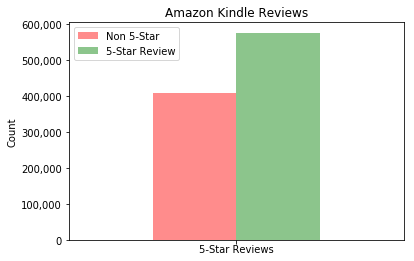

In [8]:
data['sentiment'] = data.apply(lambda row: int(row.overall > 4), axis = 1)
data_output = pd.DataFrame(columns = ['Non 5-Star', '5-Star Review'])
counts = data['sentiment'].value_counts()
data_output.loc[0] = [counts[0],counts[1]]
bars = data_output.plot.bar(title = 'Amazon Kindle Reviews', color = ['red','green'], alpha = 0.45)
bars.set_xlabel('5-Star Reviews')
plt.tick_params(labelbottom='off')  
bars.set_ylabel('Count')
bars.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()
plt.close()

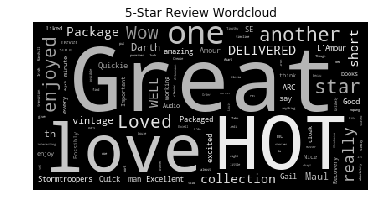

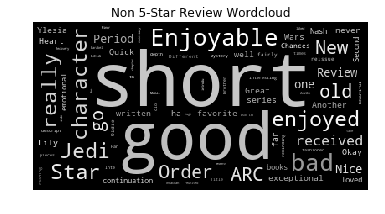

In [21]:
data['review'] = data['summary'] + ' ' + data['reviewText']
STOPWORDS.add('book')
STOPWORDS.add('story')
STOPWORDS.add('read')
make_wordcloud('5-Star Review Wordcloud',str(data[data['sentiment']==1]['review']))
make_wordcloud('Non 5-Star Review Wordcloud',str(data[data['sentiment']==0]['review']))

Next we need to tokenize and pad each review. We select a maximum number of words to consider (we choose the 1,000 words which occur most frequently in the dataset), and the maximum length of a review to consider. The average review length is well below 500 words, so I thought a max length of 500 would suffice. What we are left with is vectors with 500 entries, with each entry representing a word (represented with an integer), with 0's padding reviews that are less than 500 words. 

In [6]:
texts = list(data['review'])
max_words = 1000
maxlen = 500
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = sequence.pad_sequences(sequences,maxlen=maxlen)
Y = np.array(data['sentiment'])

Next we need to split our data up into training, validation, and testing sets. I choose to use 70% of my obersvations for training, and 15% of them for both validation and testing.

In [7]:
X_tr, X_val_tr, Y_tr, Y_val_tr = train_test_split(X, Y, test_size=0.3)
X_val, X_te, Y_val, Y_te = train_test_split(X_val_tr, Y_val_tr, test_size = 0.5)

## LSTM Models

Next we are going to take a stab at using LSTM neural networks to classify our Amazon reviews. Determining the different between a 1-star review and a 5-star review should be easy, but finding the boundary between 5-star reviews and 4-star reviews will likely prove to be a little tricky. 

Training LSTM neural networks requires a lot of computing power and can get very expensive quickly. Training these nets can take several hours, even with an EC2 instance that is meant for machine learning. For this reason, I don't add too many layers to my network, and I impose early stopping conditions. I also include callbacks to save my most effective models and to add learning rate decay to my model. Finally, I make sure to include dropout in my LSTM layers in order to avoid overfitting. 

We also include an embedding layer. This allows us to establish relationships between the words in our dataset. After each training step we not only update the model parameters, but we also update the parameters that map our unique words to vectors. It's possible that we do not have enough data to effectively define our embeddings. One thing worth exploring that is not explored in this notebook is how utilizing pre-trained embeddings such as the GloVe or Word2Vec word embeddings will effect model performance. 

In [8]:
model = models.Sequential()
model.add(Embedding(max_words,32))
model.add(LSTM(32, dropout = 0.3, recurrent_dropout=0.3))
model.add(layers.Dense(1,activation='sigmoid'))

callbacks_list = [keras.callbacks.ModelCheckpoint(
                    filepath='my_model.h5',
                    monitor='val_loss',
                    save_best_only=True
                ),
                keras.callbacks.EarlyStopping(
                    monitor='acc',
                    patience=1
                ),
                  keras.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  factor=.1,
                  patience=10
                  )
                 ]


model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_tr, Y_tr,
                    validation_data=(X_val, Y_val),
                    callbacks = callbacks_list,
                   epochs = 15,
                   batch_size = 256
                   )

Train on 687833 samples, validate on 147393 samples
Epoch 1/15
687833/687833 [==============================] - 2138s 3ms/step - loss: 0.5101 - acc: 0.7578 - val_loss: 0.4813 - val_acc: 0.7739
Epoch 2/15
687833/687833 [==============================] - 2131s 3ms/step - loss: 0.4798 - acc: 0.7759 - val_loss: 0.4635 - val_acc: 0.7831
Epoch 3/15
687833/687833 [==============================] - 2121s 3ms/step - loss: 0.4667 - acc: 0.7813 - val_loss: 0.4515 - val_acc: 0.7898
Epoch 4/15
687833/687833 [==============================] - 2123s 3ms/step - loss: 0.4591 - acc: 0.7851 - val_loss: 0.4468 - val_acc: 0.7926
Epoch 5/15
687833/687833 [==============================] - 2127s 3ms/step - loss: 0.4545 - acc: 0.7877 - val_loss: 0.4440 - val_acc: 0.7935
Epoch 6/15
687833/687833 [==============================] - 2111s 3ms/step - loss: 0.4507 - acc: 0.7894 - val_loss: 0.4411 - val_acc: 0.7963
Epoch 7/15
687833/687833 [==============================] - 2125s 3ms/step - loss: 0.4473 - acc: 0.791

Looks like we could've left the model training for a longer time, but it seems like our performance plateaus around 80% accuracy. The model generalizes well to our testing set, maintaining an accuracy of about 80%. 

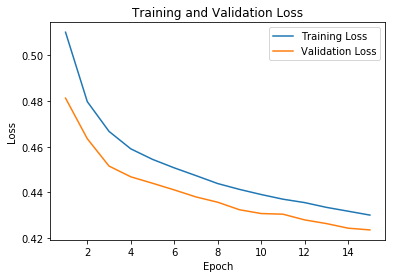

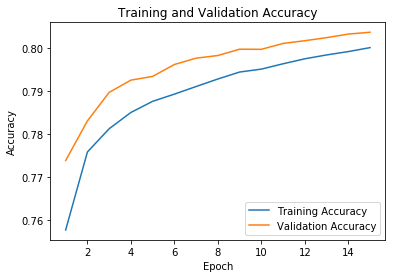

<Figure size 432x288 with 0 Axes>

In [9]:
dnn_plots(history)


Clasification report:
              precision    recall  f1-score   support

          0       0.81      0.69      0.74     61005
          1       0.80      0.88      0.84     86388

avg / total       0.80      0.80      0.80    147393



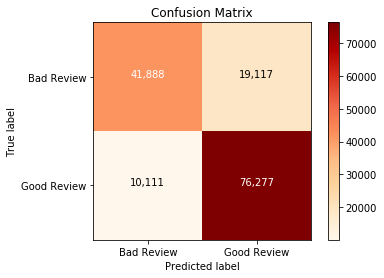

In [14]:
predictions = model.predict_classes(X_te)
plot_confusion_matrix(Y_te,predictions,['Bad Review','Good Review']).show()
plt.close()

The next thing I try is a bidirectional LSTM model, which reads our reviews from left to right _and_ reads them from right to left. Sometimes there are important signals which can only be detected when the data is passed in reverse order (for an LSTM the order matters!). 

In our case the model does not train very effectively, and, with our early stopping condition, stops training after only 2 epochs. This model is slightly less accurate on our testing set.

In [11]:
model_bidirectional = models.Sequential()
model_bidirectional.add(Embedding(max_words,32))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(32, dropout = 0.3, recurrent_dropout=0.3)))
model_bidirectional.add(layers.Dense(1,activation='sigmoid'))

callbacks_list = [keras.callbacks.ModelCheckpoint(
                    filepath='my_model_bidirectional.h5',
                    monitor='val_loss',
                    save_best_only=True
                ),
                keras.callbacks.EarlyStopping(
                    monitor='acc',
                    patience=1
                ),
                keras.callbacks.ReduceLROnPlateau(
                  monitor='val_loss',
                  factor=.1,
                  patience=10
                  )
                 ]


model_bidirectional.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history_bidirectional = model_bidirectional.fit(X_tr, Y_tr,
                    validation_data=(X_val, Y_val),
                     callbacks = callbacks_list,
                   epochs = 15,
                   batch_size =256
                   )

Train on 687833 samples, validate on 147393 samples
Epoch 1/15
687833/687833 [==============================] - 3905s 6ms/step - loss: 0.5092 - acc: 0.7577 - val_loss: 0.4786 - val_acc: 0.7763
Epoch 2/15
687833/687833 [==============================] - 3879s 6ms/step - loss: 0.4798 - acc: 0.7747 - val_loss: 0.4610 - val_acc: 0.7848


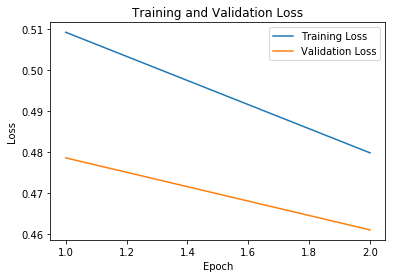

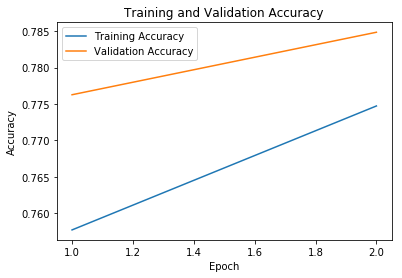

<Figure size 432x288 with 0 Axes>

In [12]:
dnn_plots(history_bidirectional)


Clasification report:
              precision    recall  f1-score   support

          0       0.78      0.66      0.72     61005
          1       0.78      0.87      0.82     86388

avg / total       0.78      0.78      0.78    147393



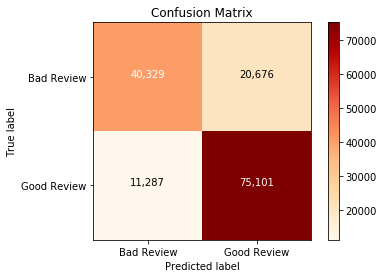

In [15]:
predictions = model_bidirectional.predict_classes(X_te)
plot_confusion_matrix(Y_te,predictions,['Bad Review','Good Review']).show()
plt.close()

## Conclusion

We were able to arrive at a model that generalized well to our testing data. Our model was around 80% accurate in classifying 5-star reviews. This task is one that might not require a neural network as complex as an LSTM. LSTM neural nets are useful because of their ability to utilize data from earlier parts of the input sequence. This might not have that much application in predicting whether or not a review will be a 5-star review.

Due to the computational intensity for an LSTM network, I did not want to spend too much time hyperparameter tuning our LSTM nets for such a task. I suspect that we can save a bunch of time, and potentially gain some accuracy by training a dense neural network on a bag of words, or, more likely, a bag of n-grams.